# Bayes-by-backprop

In [1]:
import jax
import optax
import distrax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from chex import dataclass
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from jax.flatten_util import ravel_pytree
from jaxtyping import Float, PyTree, Array
from flax.training.train_state import TrainState

from dynamax.utils import datasets

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train

# ymean = y_train.mean()
# ystd = y_train.std()
# y_train = (y_train - ymean ) / ystd

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

In [4]:
class MLP(nn.Module):
    dim_out: int
    dim_hidden: int = 100
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.dim_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        
        return x

In [11]:
key = jax.random.PRNGKey(314)
key_init, key_train, key_eval = jax.random.split(key, 3)

batch = (100, 28 ** 2)
model = MLP(1)
batch = jnp.ones(batch)

### Initialise params

In [5]:
@dataclass
class BBBParams:
    mean: PyTree[Float]
    logvar: PyTree[Float]
    

def init_bbb_params(key, model, batch_init):
    key_mean, key_logvar = jax.random.split(key)
    
    params_mean = model.init(key_mean, batch_init)
    flat_params, reconstruct_fn = ravel_pytree(params_mean)
    num_params = len(flat_params)
    
    params_logvar = jax.random.normal(key_logvar, (num_params,))
    params_logvar = reconstruct_fn(params_logvar)
    
    bbb_params = BBBParams(
        mean=params_mean,
        logvar=params_logvar,
    )
    
    return bbb_params, (reconstruct_fn, num_params)

### Define sampling functions

In [6]:
def transform(eps, mean, logvar):
    std = jnp.exp(logvar / 2)
    weight = mean + std * eps
    return weight


@partial(jax.jit, static_argnames=("num_params", "reconstruct_fn"))
def sample_params(key, state:BBBParams, num_params, reconstruct_fn:Callable):
    eps = jax.random.normal(key, (num_params,))
    eps = reconstruct_fn(eps)
    params = jax.tree_map(transform, eps, state.mean, state.logvar)
    return params


@partial(jax.jit, static_argnames=("num_params", "reconstruct_fn"))
def sample_and_eval(key, state, X, num_params, reconstruct_fn):
    params_sample = sample_params(key, state, num_params, reconstruct_fn)
    return model.apply(params_sample, X)

@jax.jit
def get_leaves(params):
    flat_params, _ = ravel_pytree(params)
    return flat_params

In [7]:
def cost_fn(
    key: jax.random.PRNGKey,
    state: BBBParams,
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    reconstruct_fn: Callable,
    scale_obs=1.0,
    scale_prior=1.0,
):
    """
    TODO:
    Add more general way to compute observation-model log-probability
    """
    
    # Sampled params
    params = sample_params(key, state, num_params, reconstruct_fn)
    params_flat = get_leaves(params)
    
    # Prior log probability (use initialised vals for mean?)
    logp_prior = distrax.Normal(loc=0.0, scale=scale_prior).log_prob(params_flat).sum()
    # Observation log-probability
    mu_obs = model.apply(params, X).ravel()
    logp_obs = distrax.Normal(loc=mu_obs, scale=scale_obs).log_prob(y).sum()
    # Variational log-probability
    logp_variational = jax.tree_map(
        lambda mean, logvar, x: distrax.Normal(loc=mean, scale=jnp.exp(logvar / 2)).log_prob(x),
        state.mean, state.logvar, params
    )
    logp_variational = get_leaves(logp_variational).sum()
    
    return logp_variational - logp_prior - logp_obs


@partial(jax.jit)
def lossfn(key, params, X, y, num_samples=10):
    # TODO: add costfn as input
    keys = jax.random.split(key, num_samples)
    cost_vmap = jax.vmap(cost_fn, in_axes=(0, None, None, None, None))
    loss = cost_vmap(keys, params, X, y, reconstruct_fn).mean()
    return loss


@partial(jax.jit, static_argnames=("num_samples", "batch_size"))
def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


In [8]:
@jax.jit
def index_values_batch(X, y, ixs):
    """
    Index values of a batch of observations
    """
    X_batch = X[ixs]
    y_batch = y[ixs]
    return X_batch, y_batch


@partial(jax.jit, static_argnames="lossfn")
def train_step(key, opt_state, X, y, lossfn):
    params = opt_state.params
    apply_fn = opt_state.apply_fn
    
    loss, grads = jax.value_and_grad(lossfn, 1)(key, params, X, y)
    opt_state_new = opt_state.apply_gradients(grads=grads)
    return opt_state_new, loss

In [9]:
def train_epoch(key, state, X, y, batch_size, lossfn):
    num_samples = len(X)
    key_batch, keys_train = jax.random.split(key)
    batch_ixs = get_batch_train_ixs(key_batch, num_samples, batch_size)
    
    num_batches = len(batch_ixs)
    keys_train = jax.random.split(keys_train, num_batches)
    
    total_loss = 0
    for key_step, batch_ix in zip(keys_train, batch_ixs):
        X_batch, y_batch = index_values_batch(X, y, batch_ix)
        state, loss = train_step(key_step, state, X_batch, y_batch, lossfn)
        total_loss += loss
    
    return total_loss.item(), state

In [12]:
batch_size = 100
num_epochs = 1000
tx = optax.adam(1e-3)
keys_epochs = jax.random.split(key_train, num_epochs)

# Bayes-by-backprop params
b3p, (reconstruct_fn, num_params) = init_bbb_params(key_init, model, batch)

opt_state = TrainState.create(
    apply_fn=model.apply,
    params=b3p,
    tx=tx
)

losses = []
for key_epoch in (pbar := tqdm(keys_epochs)):
    loss, opt_state = train_epoch(key, opt_state, X_train, y_train, batch_size, lossfn)
    pbar.set_description(f"{loss=:0.4e}")
    losses.append(loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

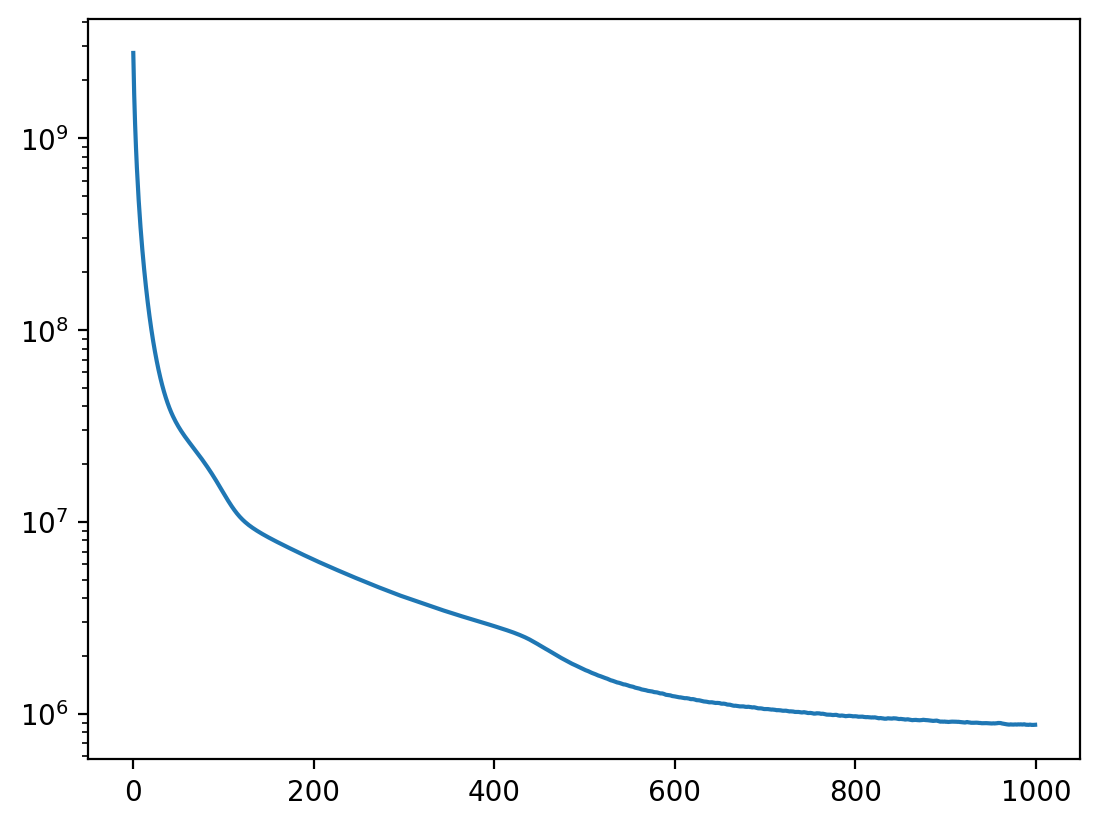

In [13]:
plt.plot(losses)
plt.yscale("log")

## Evaluating model

In [14]:
X_test, y_test = test
X_test, y_test = jnp.array(X_test), jnp.array(y_test)

### MAP

In [15]:
yhat_test = model.apply(opt_state.params.mean, X_test).ravel()

err_map = y_test - yhat_test
jnp.abs(err_map).mean()

DeviceArray(19.109356, dtype=float32)

(0.0, 180.0)

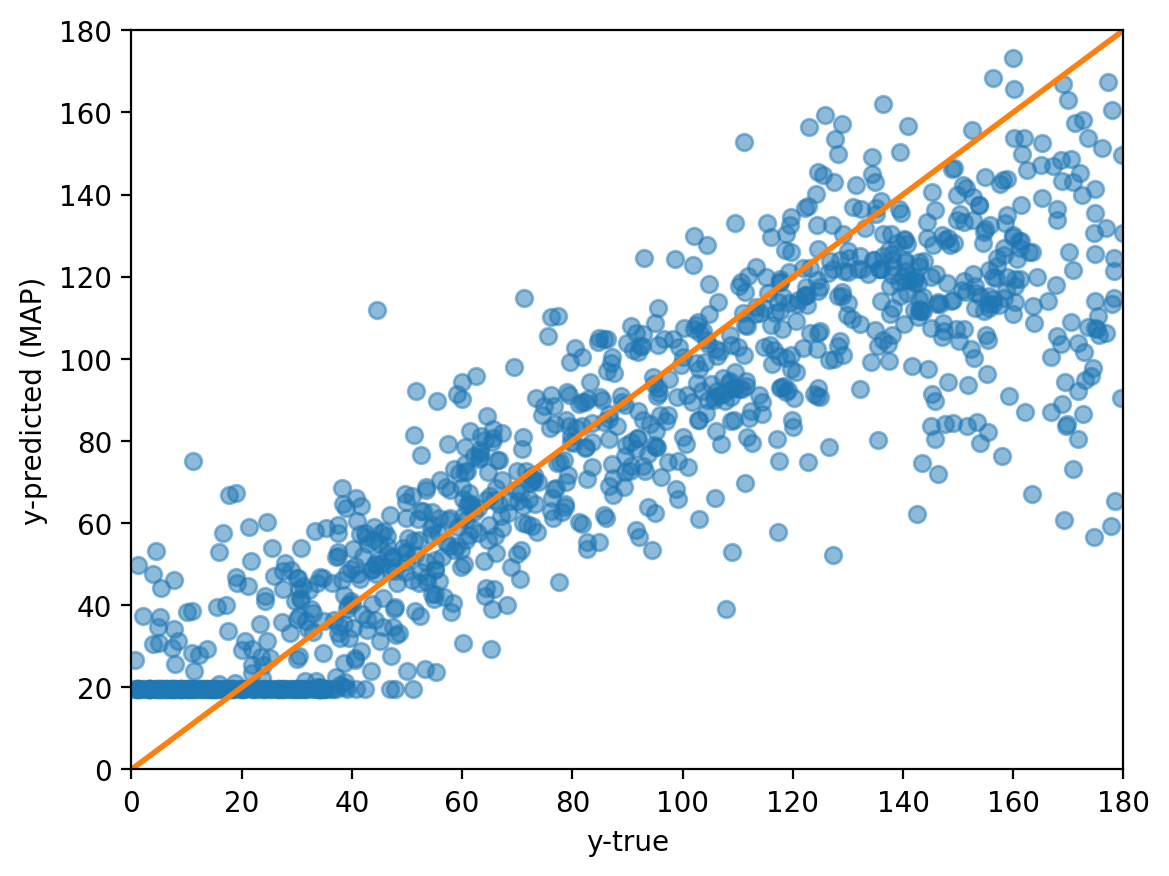

In [16]:
plt.scatter(y_test, yhat_test, alpha=0.5, edgecolors=None)
plt.ylabel("y-predicted (MAP)")
plt.xlabel("y-true")
plt.plot([0, 180], [0, 180], c="tab:orange", linewidth=2)
plt.ylim(0, 180)
plt.xlim(0, 180)

### Posterior predictive

In [21]:
@partial(jax.vmap, in_axes=(0, None, None, None, None))
@partial(jax.jit, static_argnames=("num_params", "reconstruct_fn"))
def sample_and_eval(key, state, X, num_params, reconstruct_fn):
    params_sample = sample_params(key, state, num_params, reconstruct_fn)
    return model.apply(params_sample, X)

In [25]:
keys_sample = jax.random.split(key_eval, 20)
yhat_samples = sample_and_eval(keys_sample, opt_state.params, X_test, num_params, reconstruct_fn).squeeze()
yhat_test = yhat_samples.mean(axis=0)
err_pp = y_test - yhat_test
jnp.abs(err_pp).mean()

DeviceArray(22.126667, dtype=float32)

(0.0, 180.0)

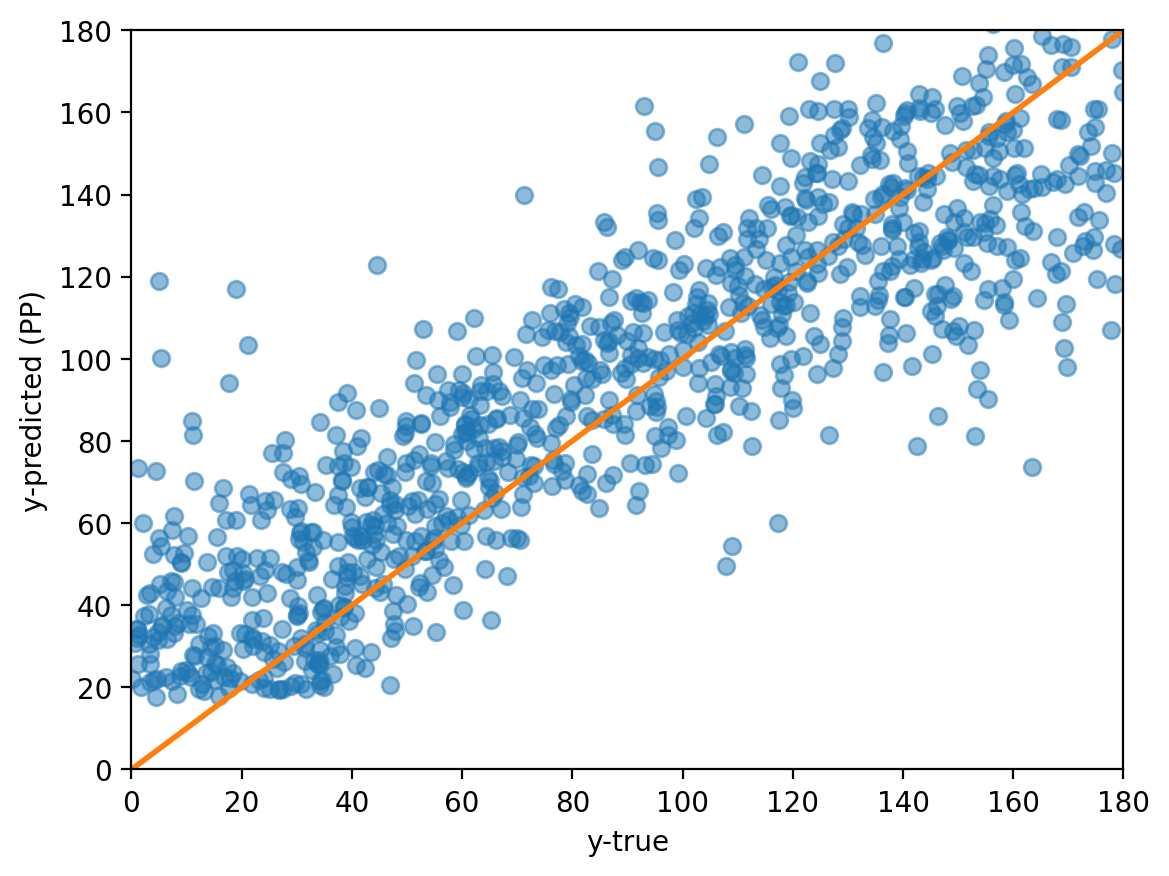

In [23]:
plt.scatter(y_test, yhat_test, alpha=0.5, edgecolors=None)
plt.ylabel("y-predicted (PP)")
plt.xlabel("y-true")
plt.plot([0, 180], [0, 180], c="tab:orange", linewidth=2)
plt.ylim(0, 180)
plt.xlim(0, 180)

## Evaluating uncertainty

In [26]:
ix_sort = jnp.argsort(y_train)
ysort_train = y_train[ix_sort]
Xsort_train = X_train[ix_sort]

In [27]:
num_bins = 20

In [28]:
bins = jnp.linspace(0, 180, 20)
bins_ix = jnp.digitize(y_train, bins)
bins_ix_test = jnp.digitize(y_test, bins)

In [29]:
bins_void = jnp.arange(7, 10)

In [30]:
map_void = jnp.isin(bins_ix, bins_void)

X_seen_train = X_train[~map_void]
y_seen_train = y_train[~map_void]

In [33]:
batch_size = 100
num_epochs = 2000
tx = optax.adam(5e-4)
keys_epochs = jax.random.split(key_train, num_epochs)

# Bayes-by-backprop params
b3p, (reconstruct_fn, num_params) = init_bbb_params(key_init, model, batch)

opt_state = TrainState.create(
    apply_fn=model.apply,
    params=b3p,
    tx=tx
)

losses = []
for key_epoch in (pbar := tqdm(keys_epochs)):
    loss, opt_state = train_epoch(key, opt_state, X_seen_train, y_seen_train, batch_size, lossfn)
    pbar.set_description(f"{loss=:0.4e}")
    losses.append(loss)

  0%|          | 0/2000 [00:00<?, ?it/s]

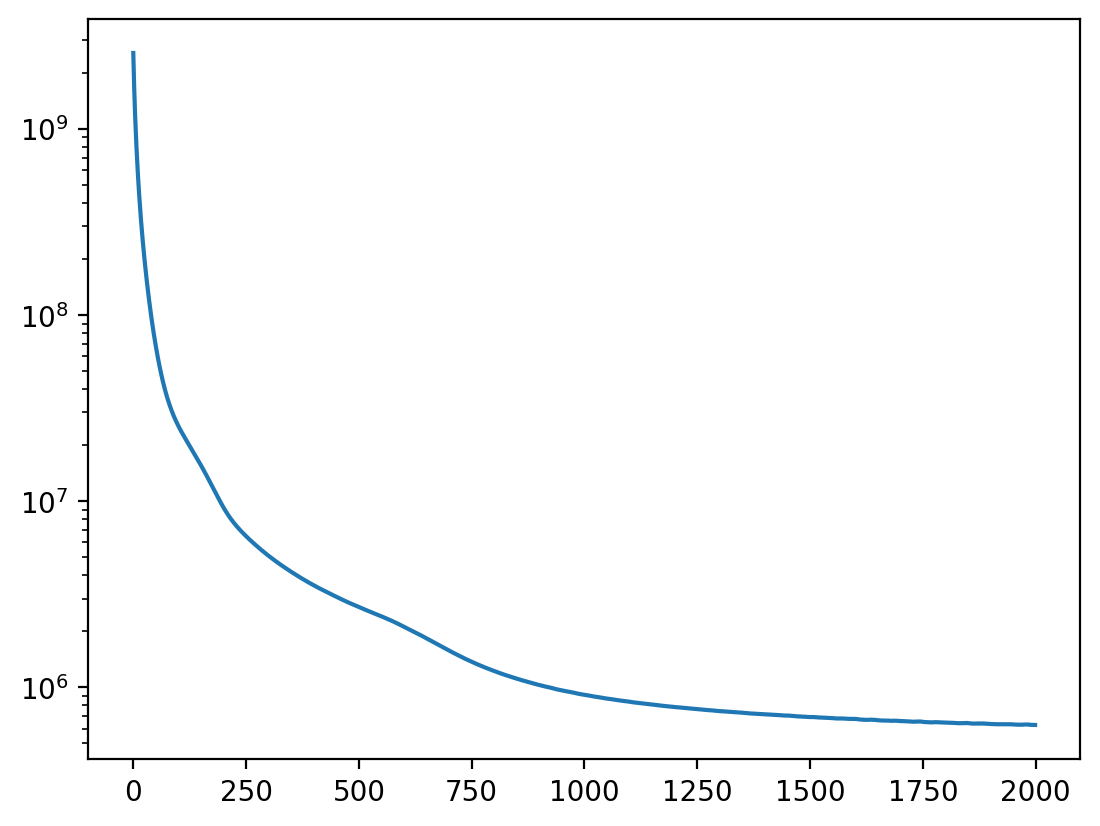

In [34]:
plt.plot(losses)
plt.yscale("log")

In [35]:
yhat_samples = sample_and_eval(keys_sample, opt_state.params, X_test, num_params, reconstruct_fn).squeeze()
yhat_test = yhat_samples.mean(axis=0)
yhat_std = yhat_samples.std(axis=0)

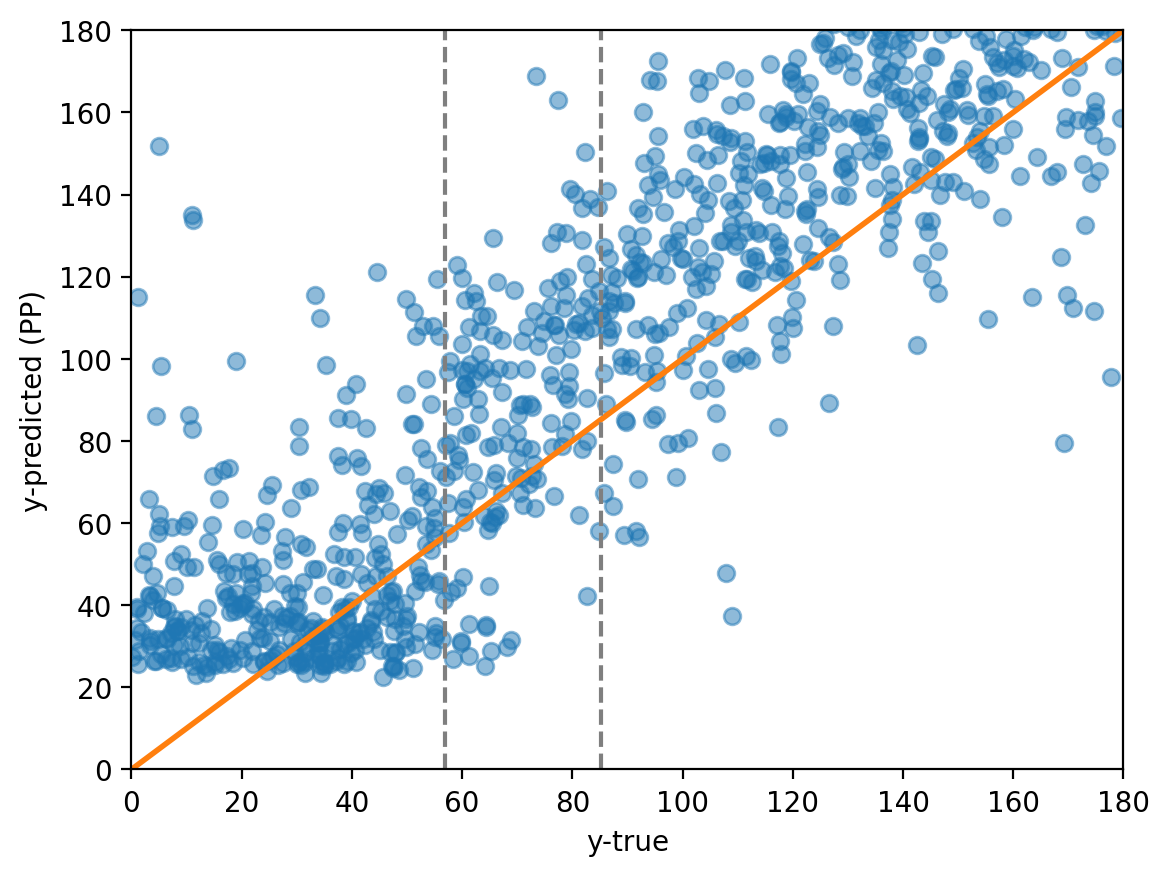

In [36]:
plt.scatter(y_test, yhat_test, alpha=0.5, edgecolors=None)
plt.ylabel("y-predicted (PP)")
plt.xlabel("y-true")
plt.plot([0, 180], [0, 180], c="tab:orange", linewidth=2)
plt.ylim(0, 180)
plt.xlim(0, 180)

lbound = y_train[map_void].min()
ubound = y_train[map_void].max()
plt.axvline(lbound, c="tab:gray", linestyle="--")
plt.axvline(ubound, c="tab:gray", linestyle="--")

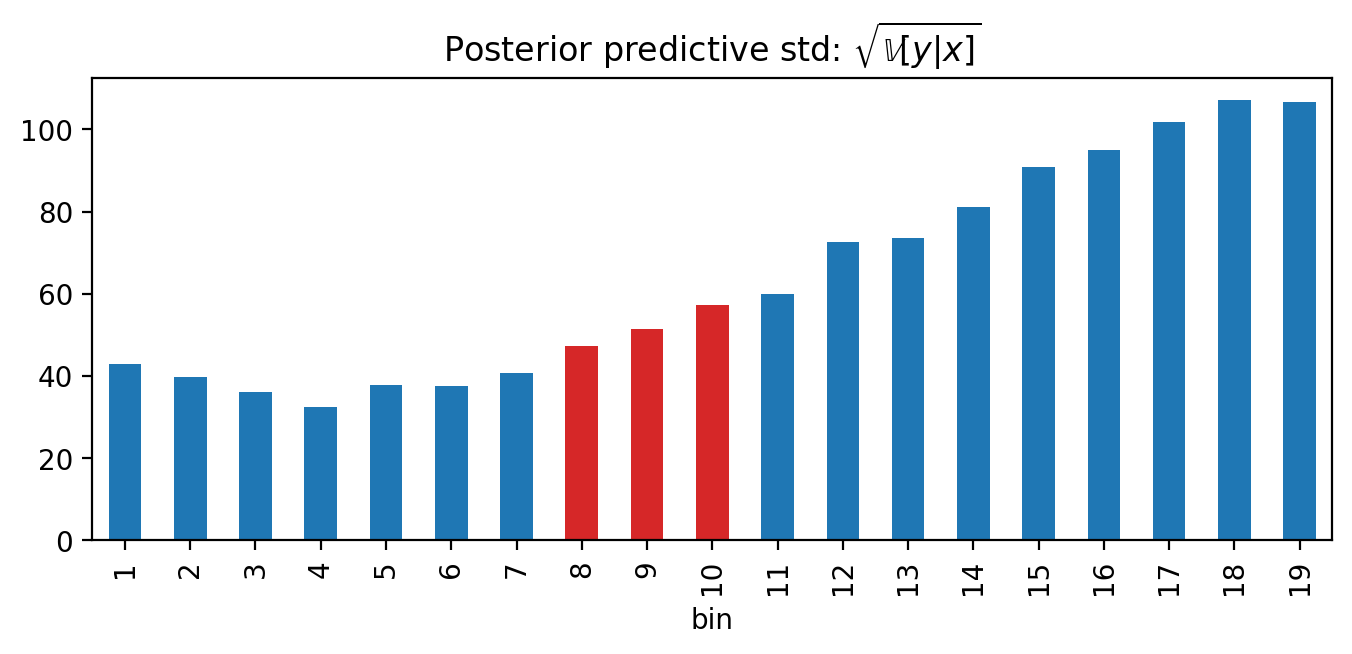

In [39]:
fig, ax = plt.subplots(figsize=(8, 3))
colors = ["tab:blue" if b not in bins_void else "tab:red" for b in range(num_bins)]

pd.DataFrame({
    "bin": bins_ix_test,
    "std": yhat_std
}).groupby("bin").mean()["std"].plot(kind="bar", color=colors)
plt.title(r"Posterior predictive std: $\sqrt{\mathbb{V}[y\vert x]}$");

## References

* [1] Laurent Valentin Jospin, Wray Buntine, Farid Boussaid, Hamid Laga, Mohammed Bennamoun: “Hands-on Bayesian Neural Networks -- a Tutorial for Deep Learning Users”, 2020, IEEE Computational Intelligence Magazine ( Volume: 17, Issue: 2, May 2022); [arXiv:2007.06823](http://arxiv.org/abs/2007.06823).